In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
from grating import *
from ext_signal import *
from scipy.stats import qmc

lum in LMS = [0.45436904 0.47353315 0.0720978 ]
[[1.31265115 0.37916654 0.17658182]
 [0.37916654 0.43588297 0.06613005]
 [0.17658182 0.06613005 1.03101131]]
[[10.82668925 -2.48855249  0.0461736 ]
 [-2.48855249  1.38614356 -0.12768065]
 [ 0.0461736  -0.12768065  1.15767798]]


In [3]:
def acuity(ecc):
    k = 0.2049795945022049
    log_cpd0 = 3.6741080244555278
    cpd = np.exp(-k*ecc + log_cpd0)
    return 1/cpd/4

acuity(0.08)

0.00644787913828977

In [4]:
K_onC = 29.13289963
K_onS = 23.17378917
K_offC = 22.71914498
K_offS = 12.53276353
r_C = (acuity(0.095) + acuity(0))/2
#r_C = 0.0065
r_S = r_C*6
cov = 0.53753
def zeroCross(k1, k2, r1, r2):
    return np.sqrt(np.log(k1/k2)/(r2*r2 - r1*r1))*r1*r2
SF = 1.0/(zeroCross(K_offC, K_onS*cov, r_C, r_S)*2 + zeroCross(K_onC, K_offS*cov, r_C, r_S)*2)
print(SF)

38.76892526756179


In [16]:
# color-drifting
crest = np.array([0.50650651, 0.27006487, 0.3609756])
valley = np.array([0.28128128, 0.48617513, 0.3609756])
#crest = np.array([0.393893895, 0.37812, 0.3609756])
#valley = np.array([0.393893895, 0.37812, 0.3609756])

inputLMS = True

#range_deg = 0.095 # eccentricity from the origin
range_deg = 0.0344#0.12672379774682216 # eccentricity from the origin
print(acuity(range_deg))
buffer_deg = acuity(range_deg)*2
print(f'range_deg = {range_deg}, buffer_deg = {buffer_deg}')
# SF = 20
SF = 5
TF = 8
time = np.array([1/TF])
neye = 1
#path = 'D:/scratch/patchV1/resource/'
#path = 'C:/Users/gueux/Repos/patchV1/Data/'
path = '/root/autodl-tmp/ljy/resource/'

0.006387891156464933
range_deg = 0.0344, buffer_deg = 0.012775782312929865


16 degree per pixel
crest in sRGB: [0.99960262 0.4916256  0.6119184 ]
valley in sRGB: [0.04124408 0.73805437 0.59827713]
0.005896972789116232 degree per pixel
ecc = 0.0344, buffer_ecc = 0.012775782312929865
1
adjusted to 1 frames in total
sharpness=1.0
16 degree per pixel
crest in sRGB: [0.99960262 0.4916256  0.6119184 ]
valley in sRGB: [0.04124408 0.73805437 0.59827713]
0.005896972789116232 degree per pixel
ecc = 0.0344, buffer_ecc = 0.012775782312929865
1
adjusted to 1 frames in total
sharpness=1.0
16 degree per pixel
crest in sRGB: [0.99960262 0.4916256  0.6119184 ]
valley in sRGB: [0.04124408 0.73805437 0.59827713]
0.005896972789116232 degree per pixel
ecc = 0.0344, buffer_ecc = 0.012775782312929865
1
adjusted to 1 frames in total
sharpness=1.0
16 degree per pixel
crest in sRGB: [0.99960262 0.4916256  0.6119184 ]
valley in sRGB: [0.04124408 0.73805437 0.59827713]
0.005896972789116232 degree per pixel
ecc = 0.0344, buffer_ecc = 0.012775782312929865
1
adjusted to 1 frames in total
sh

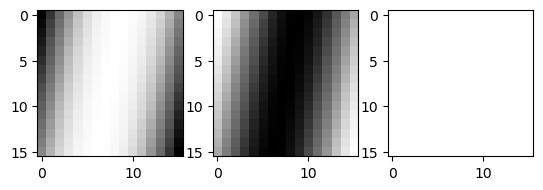

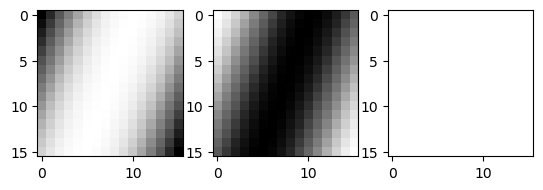

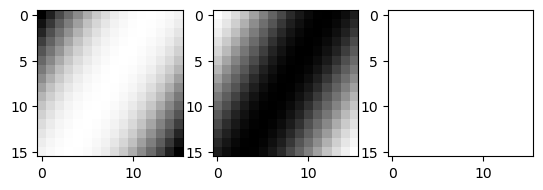

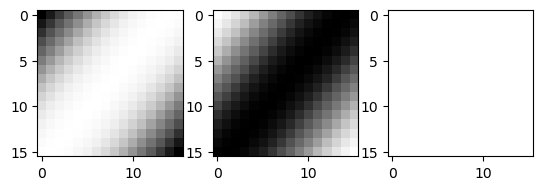

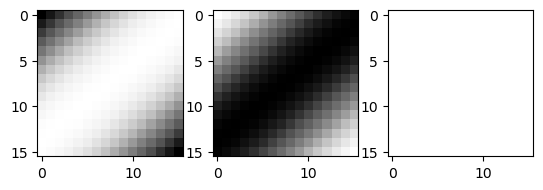

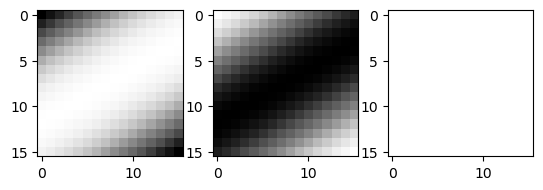

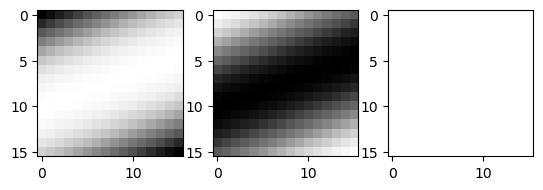

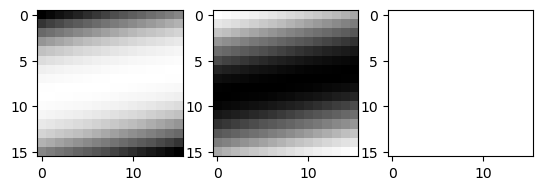

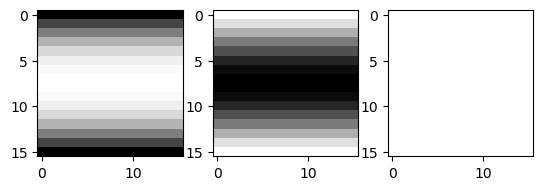

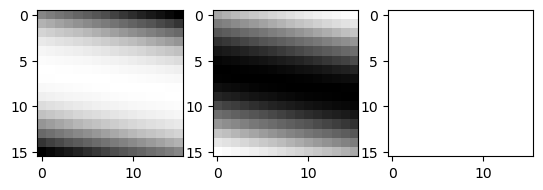

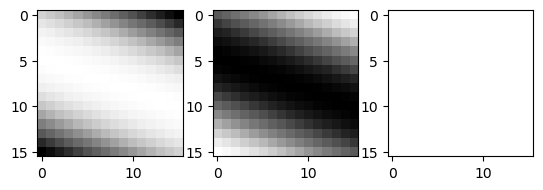

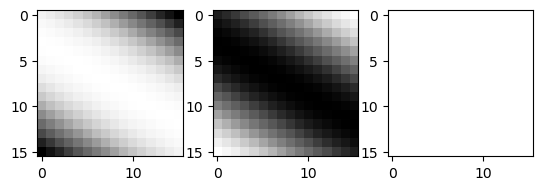

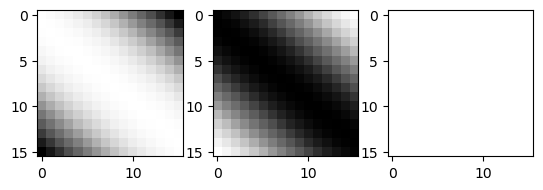

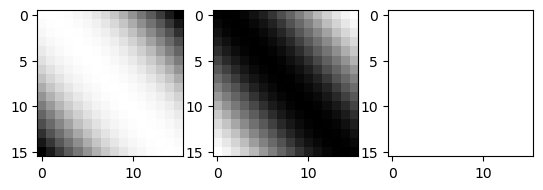

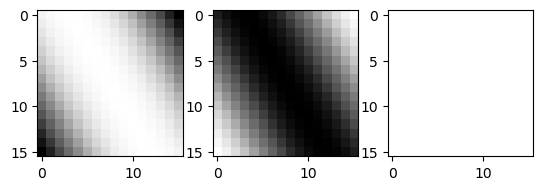

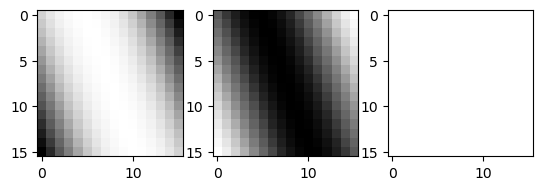

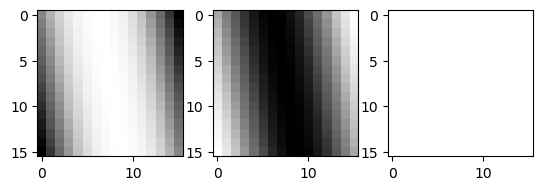

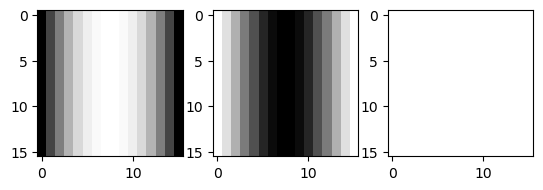

In [17]:
for iOri in range(1,19):
    video_fn = path + f'static_color-SF{SF}-TF{TF}_d{iOri}-pd'  
    orient = np.array([np.pi*iOri/18.0])
    phase = np.pi/2
    center = np.pi/2
    wing = np.pi/2
    sharpness = 1
    generate_grating(1.0, SF, TF, orient, 16, crest, valley, video_fn, time, phase, sharpness, frameRate = 1, ecc = range_deg, buffer_ecc = buffer_deg, gtype='drifting', neye = neye, bar = False, center = center, wing = wing, mask = None, inputLMS = inputLMS)
    # generate_grating(amp, spatialFrequency, temporalFrequency, direction, npixel, c1, c2, fname, time, phase, sharpness, frameRate = 120, ecc = 2.5, buffer_ecc = 0.25, gtype = 'drifting', neye = 2, bar = False, center = np.pi/2, wing = np.pi/2, mask = None, maskData = None, inputLMS = False, genMovie = True)
    # generate_grating(1.0, SF, TF, orient, 512, crest, valley, video_fn, time, phase, sharpness, frameRate = 120, ecc = range_deg, buffer_ecc = buffer_deg, gtype='drifting', neye = neye, bar = False, center = center, wing = wing, mask = None, inputLMS = inputLMS)    

In [7]:
sharpness[0]

TypeError: 'int' object is not subscriptable

In [9]:
# setup random
nc = 10
c1 = np.array([0.50650651, 0.27006487, 0.3609756])
c0 = np.array([0.3938938,0.37812,0.3609756])
c_1 = np.array([0.28128128, 0.48617513, 0.3609756])
L = np.linspace(c_1[0],c1[0],nc).reshape(nc,1)
M = np.linspace(c_1[1],c1[1],nc).reshape(nc,1)
S = np.linspace(c_1[2],c1[2],nc).reshape(nc,1)
c = np.hstack((L,M,S))
print(c.shape)
inputLMS = True
seed = 6518743
range_deg = 0.095 # eccentricity from the origin
buffer_deg = acuity(range_deg)*6*2
print(f'range_deg = {range_deg}, buffer_deg = {buffer_deg}')
time = time = [20]

(10, 3)
range_deg = 0.095, buffer_deg = 0.07761281883136265


In [10]:
# generate random
video_fn = 'random-2color-p60'
stimulus_fn = video_fn + '.bin'
radius = (acuity(range_deg) + acuity(0))/2
nseq = len(time)
amp = 1
generate_random(amp, radius, 256, c, video_fn, time, frameRate = 60, ecc = range_deg, buffer_ecc = buffer_deg, neye = 2, seed = seed, gtype='randomPhase')

0.0019548877942400416 degree per pixel
frame size: 128x256, radius in pixel 3
ecc = 0.095, buffer_ecc = 0.07761281883136265
1200 frames in total


[0.00320839 0.00552573]
xrange [-0.12, 0.21999999999999997]
yrange [-0.33999999999999997, 0.33999999999999997]
masking at [0.00320839 0.00552573] for a radius of 0.0325334
1869 (1.426%) pixel(s) left unmasked
masking at [0.00320839 0.00552573] for a radius of 0.03904008
2694 (2.055%) pixel(s) left unmasked
512 degree per pixel
0.0013281249999999999 degree per pixel
ecc = 0.1, buffer_ecc = 0.12
240
exact 60 frames in total
sharpness=1.0
exact 60 frames in total
sharpness=1.0


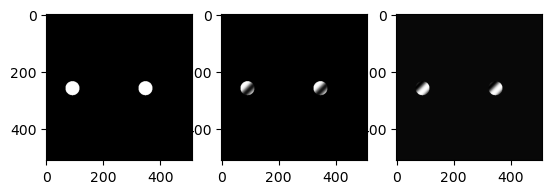

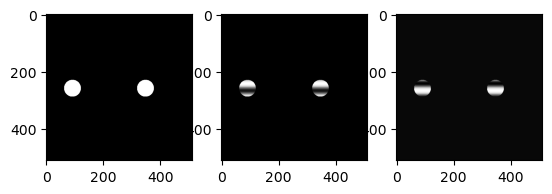

In [11]:
# masking
video_fn = 'test_mask'
stimulus_fn = video_fn + '.bin'
buffer_deg = 0.12
range_deg = 0.1 # eccentricity from the original
crest = np.array([0.50650651, 0.27006487, 0.3609756])
valley = np.array([0.28128128, 0.48617513, 0.3609756])
SF = 15
TF = 8
#orient = np.array([np.pi/4, np.pi*3/4])
orient = np.array([np.pi*1/4, np.pi*1/2])
time = [0.5, 0.5]
nseq = len(time)
sharpness = 1
phase = 12*np.pi/2
center_phase = np.pi/2
wing = np.pi/2
inputLMS = False
mask_value = [0.5,0.5,0.5]
radius = [0.0325334, 0.0325334*1.2]
neye = 2
seed = 1487432
mask_center = None
mask = generate_circular_mask(512, radius, seed, range_deg, buffer_deg, neye, center = mask_center)

LMS_series = generate_grating(1.0, SF, TF, orient, 512, crest, valley, video_fn, time, phase, sharpness, frameRate = 120, ecc = range_deg, buffer_ecc = buffer_deg, gtype='drifting', neye = neye, bar = False, center = center_phase, wing = wing, mask = mask, maskData = mask_value, inputLMS = inputLMS)

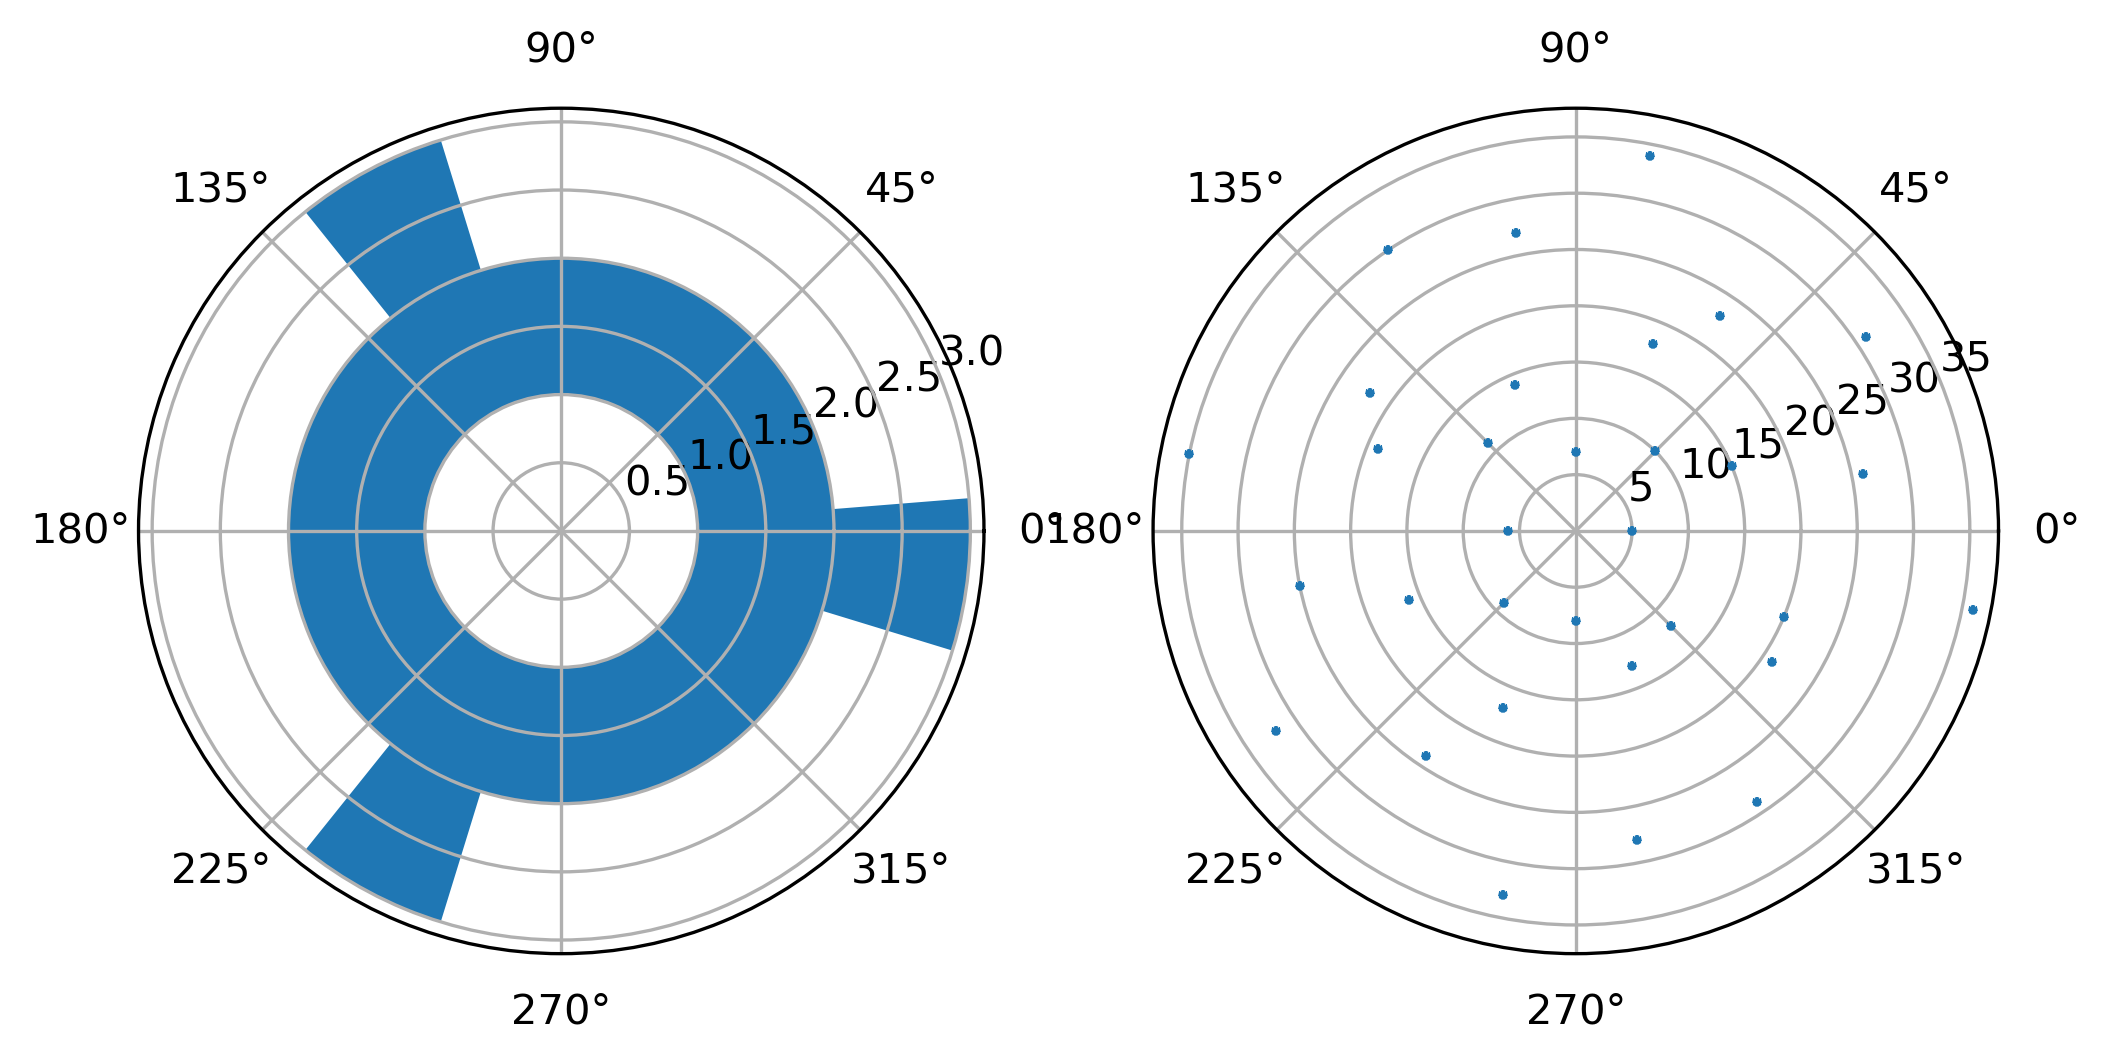

In [12]:
# setup stage II retinal waves 
path = 'D:/scratch/patchV1/resource/'
theme = 'stage_II'
nseq = 32
nrepeat = 1 # of each seq
range_deg0 = 6 # the starting eccentricity of the wave
range_deg = 10 # the eccentricity of the visual field
seed = 3917563
seq_type = 'opponent'
if nrepeat > 1:
    fn = f'{nseq}x{nrepeat}-{seq_type}'
else:
    fn = f'{nseq}-{seq_type}'
if seq_type == 'random':
    fn = fn + f'{seed}_{range_deg}-{range_deg0}_{theme}'
else:
    fn = fn + f'_{range_deg}-{range_deg0}_{theme}'
video_fn = path + fn
reverse = False
resolution = 128
speed = 4.0 # degree/s
range_deg = 10.0 # eccentricity from the original
SF = np.array([1/20, 1/20])
center = np.pi/2
wing = np.pi/2
amp = np.array([1.0,1.0])
overlap = 1
sharpness = np.array([-1,-1])
phase = np.zeros(2) # initialize, make sure size is correct
frameRate = 30

sampler = qmc.Sobol(d=1, scramble=False, seed = seed)
rng = np.random.default_rng(seed)
match seq_type:
    case 'opponent':
        orient = (sampler.random(nseq)*np.pi*2).reshape(nseq)
    case 'random':
        orient = rng.permutation(np.arange(nseq)/nseq*np.pi*2)
    case 'sequential':
        dorient = np.pi*2/nseq
        orient = np.linspace(0, np.pi*2-dorient, nseq)
    case other:
        if type(seq_type) == int or float:
            orient = np.array([seq_type*np.pi/180]*nseq)
        else:
            raise Exception('not implemented')

# video file has x-axis flipped orientation
flipped_orient = 2*np.pi - orient
sliced = np.arange(nseq)
fig = plt.figure('orient dist.', figsize = (8,4), dpi =300)
ax = fig.add_subplot(121, polar=True)
edges = np.linspace(0, 2*np.pi, 30)
counts, _ = np.histogram(flipped_orient[sliced], bins=edges)
centers = (edges[:-1] + edges[1:])/2
radi = max(min(counts),1)
nbins = 10
ax.bar(centers, counts, width = 2*np.pi*radi/nbins*0.6, bottom=radi)
ax = fig.add_subplot(122, polar=True)
nsliced = sliced.size
ax.plot(flipped_orient[sliced], np.arange(nsliced)+5,'*', ms = 2.0)
#orient = np.pi/4
#print(f'wave orientation: {orient*180/np.pi}')
virtual_LGN = 0

In [13]:
# generate retinal waves 
stimulus_fn = video_fn + '.bin'

TF = SF*speed
dDis = (1-overlap)*2*wing/(np.pi*2)/SF[0]
waveLength0 = np.sum(2*wing/(np.pi*2)/SF)
burst_period = 2*wing/(np.pi*2)/SF[1] + dDis
waveSF = 1.0/(waveLength0 + range_deg0*2 - (waveLength0 - burst_period))
waveTF = waveSF*speed
dphase = dDis*waveSF*2*np.pi
extend_finish = 2*range_deg0*np.sqrt(2) - (1/waveSF - burst_period)
fullDis = 1/waveSF + extend_finish
time = np.zeros(nseq) + fullDis/speed
phase[0] = -np.pi*2*(range_deg0*np.sqrt(2)*waveSF) - np.pi
phase[1] = phase[0] - dphase
print(f'waveLength0 = {waveLength0} >= burst_period = {burst_period} >= dDis = {dDis}')
print(f'TF = {TF}, SF = {SF}, speed = {speed} deg/s')
print(f'waveLength = {1/waveSF}, waveTF = {waveTF} Hz')
print(f'phase = {phase*180/np.pi} deg')
print(f'full width of bar = {1/SF * wing/np.pi} degrees, time = {time}')
print(f'frames to repeat = {1/waveSF/speed*frameRate:.1f}, frames for finish = {extend_finish/speed*frameRate:.1f}')


framesPerStatus = int(np.ceil(1/waveSF/speed*frameRate))
framesToFinish = int(np.ceil(extend_finish/speed*frameRate))
framesPerOri = framesPerStatus + framesToFinish
totalframes = framesPerOri*nseq
print(f'{framesPerOri}x{nseq}, total number of frames: {totalframes}')

waveLength0 = 20.0 >= burst_period = 10.0 >= dDis = 0.0
TF = [0.2 0.2], SF = [0.05 0.05], speed = 4.0 deg/s
waveLength = 22.0, waveTF = 0.18181818181818182 Hz
phase = [-318.85005885 -318.85005885] deg
full width of bar = [10. 10.] degrees, time = [6.74264069 6.74264069 6.74264069 6.74264069 6.74264069 6.74264069
 6.74264069 6.74264069 6.74264069 6.74264069 6.74264069 6.74264069
 6.74264069 6.74264069 6.74264069 6.74264069 6.74264069 6.74264069
 6.74264069 6.74264069 6.74264069 6.74264069 6.74264069 6.74264069
 6.74264069 6.74264069 6.74264069 6.74264069 6.74264069 6.74264069
 6.74264069 6.74264069]
frames to repeat = 165.0, frames for finish = 37.3
203x32, total number of frames: 6496


In [14]:
generate_retinal_wave(amp, SF, TF, waveSF, waveTF, orient, phase, sharpness, resolution, video_fn, time, frameRate = frameRate, ecc = range_deg, gtype='drifting', neye = 1, bar = True, center = center, wing = wing, virtual_LGN = virtual_LGN, nrepeat = 1, reverse = reverse)

0.15625 degree per pixel
ecc = 10.0


FileNotFoundError: [Errno 2] No such file or directory: 'D:/scratch/patchV1/resource/32-opponent_10-6_stage_II.bin'

In [ ]:
with open(video_fn+'.cfg', 'wb') as f:
    np.array([1, nseq, nrepeat]).astype('u4').tofile(f)
    np.array([frameRate], dtype = float).tofile(f)
    np.array([framesPerStatus, framesToFinish]).astype('u4').tofile(f)
    np.array([range_deg], dtype = float).tofile(f)

In [ ]:
with open(video_fn + '.cfg', 'r') as f:
    _ = np.fromfile(f, 3, 'u4')
    _ = np.fromfile(f, 1, 'f8')
    framesPerStatus, framesToFinish = np.fromfile(f, 2, 'u4')

In [ ]:
# setup stage III retinal waves
path = 'D:/scratch/patchV1/resource/'
theme = 'stage_III_sym'
nseq = 32
nrepeat = 3 # of each seq
range_deg0 = 5 # the starting eccentricity of the wave
range_deg = 5 # the eccentricity of the visual field
seed = 3917563
seq_type = 135
if seq_type == 'random':
    fn = f'{nseq}x{nrepeat}-{seq_type}{seed}_{range_deg}-{range_deg0}_{theme}'
else:
    fn = f'{nseq}x{nrepeat}-{seq_type}_{range_deg}-{range_deg0}_{theme}'
video_fn = path + fn
reverse = False
resolution = 128
speed = 5.0 # degree/s
SF = np.array([1/8, 1/8])
center = np.pi/2
wing = np.pi/2
amp = np.array([1.0,1.0])
overlap = 0
sharpness = np.array([-1,-1])
phase = np.zeros(2) # initialize, make sure size is correct
frameRate = 30

sampler = qmc.Sobol(d=1, scramble=False, seed = seed)
rng = np.random.default_rng(seed)
match seq_type:
    case 'opponent':
        orient = (sampler.random(nseq)*np.pi*2).reshape(nseq)
    case 'random':
        orient = rng.permutation(np.arange(nseq)/nseq*np.pi*2)
    case 'sequential':
        dorient = np.pi*2/nseq
        orient = np.linspace(0, np.pi*2-dorient, nseq)
    case other:
        if type(seq_type) == int or float:
            orient = np.array([seq_type*np.pi/180]*nseq)
        else:
            raise Exception('not implemented')

sliced = np.arange(nseq)
flipped_orient = 2*np.pi - orient
fig = plt.figure('orient dist.', figsize = (8,4), dpi =300)
ax = fig.add_subplot(121, polar=True)
edges = np.linspace(0, 2*np.pi, 12)
#print(edges)
counts, _ = np.histogram(flipped_orient[sliced], bins=edges)
#print(counts)
centers = (edges[:-1] + edges[1:])/2
radi = max(min(counts),1)
nbins = 10
ax.bar(centers, counts, width = 2*np.pi*radi/nbins*0.6, bottom=radi)
ax = fig.add_subplot(122, polar=True)
nsliced = sliced.size
ax.plot(flipped_orient[sliced], np.arange(nsliced)+1,'*', ms = 2.0)
#orient = np.pi/4
#print(f'wave orientation: {orient*180/np.pi}')
virtual_LGN = 0

In [ ]:
# generate stage III retinal waves 
stimulus_fn = video_fn + '.bin'

TF = SF*speed
dDis = (1-overlap)*2*wing/(np.pi*2)/SF[0]
waveLength0 = np.sum(2*wing/(np.pi*2)/SF)
burst_period = 2*wing/(np.pi*2)/SF[1] + dDis
waveSF = 1.0/(waveLength0 + range_deg0*2 - (waveLength0 - burst_period))
waveTF = waveSF*speed
dphase = dDis*waveSF*2*np.pi
extend_finish = 2*range_deg0*np.sqrt(2) - (1/waveSF - burst_period)
fullDis = 1/waveSF*nrepeat + extend_finish
time = np.zeros(nseq) + fullDis/speed
phase[0] = -np.pi*2*(range_deg0*np.sqrt(2)*waveSF) - np.pi
phase[1] = phase[0] - dphase
print(f'waveLength0 = {waveLength0} >= burst_period = {burst_period} >= dDis = {dDis}')
print(f'TF = {TF}, SF = {SF}, speed = {speed} deg/s')
print(f'waveLength = {1/waveSF}, waveTF = {waveTF} Hz')
print(f'phase = {phase*180/np.pi} deg')
print(f'full width of bar = {1/SF * wing/np.pi} degrees, time = {time}')
print(f'frames to repeat = {1/waveSF/speed*frameRate:.1f}x{nrepeat}, frames for finish = {extend_finish/speed*frameRate:.1f}')

framesPerStatus = int(np.ceil(1/waveSF/speed*frameRate))
framesToFinish = int(np.ceil(extend_finish/speed*frameRate))
framesPerOri = framesPerStatus*nrepeat + framesToFinish
totalframes = framesPerOri*nseq
print(f'{framesPerOri}x{nseq}, total number of frames: {totalframes}')

In [ ]:
generate_retinal_wave(amp, SF, TF, waveSF, waveTF, orient, phase, sharpness, resolution, video_fn, time, frameRate = frameRate, ecc = range_deg, gtype='drifting', neye = 1, bar = True, center = center, wing = wing, ecc0 = range_deg0, virtual_LGN = virtual_LGN, nrepeat = nrepeat, reverse = reverse)

In [ ]:
with open(video_fn+'.cfg', 'wb') as f:
    np.array([1, nseq, nrepeat]).astype('u4').tofile(f)
    np.array([frameRate], dtype = float).tofile(f)
    np.array([framesPerStatus, framesToFinish]).astype('u4').tofile(f)
    np.array([range_deg], dtype = float).tofile(f)

In [ ]:
# setup standing wave
nseq = 1
nrepeat = 1 # of each seq
video_fn = f'standing_wave0'
resolution = 128
seed = 6546653
speed = 0.0 # degree/s
range_deg = 5.0 # eccentricity from the original
SF = np.array([1/8, 1/16])
center = np.pi/2
wing = np.pi/2
amp = np.array([1.0,1.0])
overlap = 0
sharpness = np.array([-1,-1])
phase = np.zeros(2) # initialize, make sure size is correct
frameRate = 30

np.random.seed(seed)
#orient = np.array([np.pi*1/4, np.pi*1/2, np.pi*3/4, np.pi])
#orient = np.array([np.pi*1/4, np.pi*3/4])
#orient = np.random.rand(nseq)*2*np.pi
orient = np.pi/2
print(f'wave orientation: {orient*180/np.pi}')
virtual_LGN = 0

In [ ]:
# generate retinal waves 
stimulus_fn = video_fn + '.bin'

TF = SF*speed
dDis = (1-overlap)*2*wing/(np.pi*2)/SF[0]
waveLength0 = np.sum(2*wing/(np.pi*2)/SF)
burst_period = 2*wing/(np.pi*2)/SF[1] + dDis
waveSF = 1.0/(waveLength0 + range_deg*2 - (waveLength0 - burst_period))
waveTF = waveSF*speed
dphase = dDis*waveSF*2*np.pi
fullDis = 1/waveSF*nrepeat + 2*range_deg*np.sqrt(2) - (1/waveSF - burst_period) 
time = 1
#phase[0] = -np.pi*2*(range_deg*np.sqrt(2)*waveSF) - np.pi
phase[0] = -4/22 * 2*np.pi - np.pi/8
phase[1] = phase[0] - dphase
print(f'waveLength0 = {waveLength0} >= burst_period = {burst_period} >= dDis = {dDis}')
print(f'TF = {TF}, SF = {SF}, speed = {speed} deg/s')
print(f'waveLength = {1/waveSF}, waveTF = {waveTF} Hz')
print(f'phase = {phase*180/np.pi} deg')
print(f'full width of bar = {1/SF * wing/np.pi} degrees, time = {time}')
generate_retinal_wave(amp, SF, TF, waveSF, waveTF, orient, phase, sharpness, resolution, video_fn, time, frameRate = frameRate, ecc = range_deg, gtype='drifting', neye = 1, bar = True, center = center, wing = wing, virtual_LGN = virtual_LGN, nrepeat = nrepeat)

In [ ]:
stimulus_fn = 'stimulus.bin'
with open(stimulus_fn, 'rb') as f:
    np.array([LMS_series[0].shape[0], LMS_series[0].shape[2], LMS_series[0].shape[3]], dtype='i4').tofile(f)
    mean_value = np.array([np.mean(LMS_series[0][:,0,:,:]), np.mean(LMS_series[0][:,1,:,:]), np.mean(LMS_series[0][:,2,:,:])])
    mean_value.astype('f4').tofile(f) # init_luminance
    np.array([buffer_deg, range_deg], dtype='f4').tofile(f)
    for i in range(nseq):
        LMS_series[i].astype('f4').tofile(f)

dpi = 600
fig = plt.figure('LMS revisit', dpi = dpi)
it = 0
iseq = 0
npixel = 512
xx, yy = np.meshgrid(np.arange(npixel), np.arange(npixel))
ax = fig.add_subplot(121)
tristimulus_value = np.reshape(LMS_series[iseq][it,:,:,:], (3,xx.size))
assert((tristimulus_value>=0).all())
assert((tristimulus_value<=1).all())
if inputLMS:
    tristimulus_value = np.matmul(LMS2sRGB, tristimulus_value)
    if (tristimulus_value<0).any() or (tristimulus_value>1).any():
        print(np.max(tristimulus_value))
        print(np.min(tristimulus_value))
        assert((tristimulus_value>=0).all())
        assert((tristimulus_value<=1).all())
    tristimulus_value = apply_sRGB_gamma(tristimulus_value)

color = tristimulus_value.T

ax.scatter(xx.flatten(), yy.flatten(), s = (72/dpi*10)**2, c = color, marker='.',linewidths=0.0)
ax.set_xlim([0,npixel])
ax.set_ylim([0,npixel])
ax.set_aspect('equal')
ax = fig.add_subplot(122)
it = 1

tristimulus_value = np.reshape(LMS_series[iseq][it, :, :,:], (3,xx.size))
assert((tristimulus_value>=0).all())
assert((tristimulus_value<=1).all())
if inputLMS:
    tristimulus_value = np.matmul(LMS2sRGB, tristimulus_value)
    if (tristimulus_value<0).any() or (tristimulus_value>1).any():
        print(np.max(tristimulus_value))
        print(np.min(tristimulus_value))
        assert((tristimulus_value>=0).all())
        assert((tristimulus_value<=1).all())
    tristimulus_value = apply_sRGB_gamma(tristimulus_value)
color = tristimulus_value.T

ax.scatter(xx.flatten(), yy.flatten(), s = (72/dpi*10)**2, c = color, marker='.',linewidths=0.0)
ax.set_xlim([0,npixel])
ax.set_ylim([0,npixel])
ax.set_aspect('equal')

In [ ]:
#video_fn = 'L-isolating'
# sRGB compatible
#crest = np.array([0.59059059, 0.49999039, 0.49991416])
#valley = np.array([0.40940941, 0.49999039, 0.49991416])
# XYZ
# CAT02
#crest = np.array([0.78178178, 0.49999038, 0.49991416])
#valley = np.array([0.24524525, 0.49999038, 0.49991416])

#video_fn = 'M-isolating'
# sRGB compatible
#crest = np.array([0.49998918, 0.60760761, 0.49991416])
#valley = np.array([0.49998918, 0.39239239, 0.49991416])
# XYZ
# CAT02
#crest = np.array([0.49998918, 0.91991992, 0.49991416]) 
#valley = np.array([0.49998918, 0.03603604, 0.49991416])


video_fn = 'equiluminant_d2'
# sRGB compatible
#crest = np.array([0.56156156, 0.46516206, 0.49991416])
#valley = np.array([0.43843844, 0.53478416, 0.49991416])

# XYZ space
# CAT02
crest = np.array([0.89289289, 0.2819068, 0.54363796])
valley = np.array([0.16016016, 0.98498549, 0.54363796])
# Hunt 
#crest = np.array([0.70970971, 0.38138913, 0.49991416])
#valley = np.array([0.31031031, 0.60723642, 0.49991416])

inputLMS = True
buffer_deg = 1.0
range_deg = 2.5 # eccentricity from the origin
TF = 8
SF = 3

orient = np.array([np.pi*1/4])
time = np.array([0.125])
phase = 8.8*np.pi
center = np.pi/2
wing = np.pi/2
sharpness = 1
LMS_series = generate_grating(1.0, SF, TF, orient, 512, crest, valley, video_fn, time, phase, sharpness, frameRate = 120, ecc = range_deg, buffer_ecc = buffer_deg, gtype='drifting', neye = 2, bar = False, center = center, wing = wing, inputLMS = inputLMS)

print(LMS_series.shape)
nseq = LMS_series.size
for i in range(nseq):
    print([np.min(LMS_series[i]), np.max(LMS_series[i])])

stimulus_fn = video_fn + '.bin'
with open(stimulus_fn, 'wb') as f:
    np.array([LMS_series[0].shape[0], LMS_series[0].shape[2], LMS_series[0].shape[3]], dtype='i4').tofile(f)
    mean_value = np.array([np.mean(LMS_series[0][:,0,:,:]), np.mean(LMS_series[0][:,1,:,:]), np.mean(LMS_series[0][:,2,:,:])])
    mean_value.astype('f4').tofile(f) # init_luminance
    np.array([buffer_deg, range_deg], dtype='f4').tofile(f)
    print([buffer_deg, range_deg])
    for i in range(nseq):
        print(i)
        LMS_series[i].astype('f4').tofile(f)
print(mean_value)

In [ ]:
crest = np.array([0.89289289, 0.2819068, 0.54363796])
valley = np.array([0.16016016, 0.98498549, 0.54363796])
mL = (crest[0] + valley[0])/2
mM = (crest[1] + valley[1])/2
print(f'{crest[0]/mL - 1, mL, valley[0]/mL - 1}')
print(f'{crest[1]/mM - 1, mM, valley[1]/mM - 1}')

In [ ]:
# cyclop
video_fn = 'light_bar_cyclop_flat'
stimulus_fn = video_fn + '.bin'
crest = [255,255,255]
valley = [0,0,0]
buffer_deg = 0.525
range_deg = 0.25 # eccentricity from the origin
SF = 4
TF = 8
#nseq = 2
#orient = np.array([np.pi*1/4, np.pi*3/4])
#time = [0.5, 0.5]
#time = np.array([1.2, 1.2])
#orient = np.array([np.pi*1/4, np.pi*3/4])
orient = 0
time = np.array([1.2])
#phase = 8.8*np.pi
phase = 3*np.pi
center = np.pi/2
wing = np.pi/2
sharpness = 1
LMS_series = generate_grating(1.0, SF, TF, orient, 256, crest, valley, video_fn, time, phase, sharpness, frameRate = 120, ecc = range_deg, buffer_ecc = buffer_deg, gtype='drifting', neye = 1, bar = True, center = center, wing = wing)
#start = 0
#end = 60
#LMS_inRGB = video_to_LMS_time_series('test', start, end)
print(LMS_series.shape)
nseq = LMS_series.size
for i in range(nseq):
    print([np.min(LMS_series[i]), np.max(LMS_series[i])])

with open(stimulus_fn, 'wb') as f:
    np.array([LMS_series[0].shape[0], LMS_series[0].shape[2], LMS_series[0].shape[3]], dtype='i4').tofile(f)
    mean_value = np.array([np.mean(LMS_series[0][:,0,:,:]), np.mean(LMS_series[0][:,1,:,:]), np.mean(LMS_series[0][:,2,:,:])])
    mean_value.astype('f4').tofile(f) # init_luminance
    np.array([buffer_deg, range_deg], dtype='f4').tofile(f)
    print([buffer_deg, range_deg])
    for i in range(nseq):
        LMS_series[i].astype('f4').tofile(f)
print(mean_value)

In [ ]:
# cyclop
video_fn = 'light_bar_cyclop_orth'
stimulus_fn = video_fn + '.bin'
crest = [255,255,255]
valley = [0,0,0]
buffer_deg = 0.525
range_deg = 0.25 # eccentricity from the origin
SF = 4
TF = 8

orient = np.array([np.pi*3/4, np.pi*1/4])
time = np.array([1.2, 1.2])
phase = 8.8*np.pi
center = np.pi/2
wing = np.pi/2
sharpness = 1
LMS_series = generate_grating(1.0, SF, TF, orient, 256, crest, valley, video_fn, time, phase, sharpness, frameRate = 120, ecc = range_deg, buffer_ecc = buffer_deg, gtype='drifting', neye = 1, bar = True, center = center, wing = wing)
#start = 0
#end = 60
#LMS_inRGB = video_to_LMS_time_series('test', start, end)
print(LMS_series.shape)
nseq = LMS_series.size
for i in range(nseq):
    print([np.min(LMS_series[i]), np.max(LMS_series[i])])

with open(stimulus_fn, 'wb') as f:
    np.array([LMS_series[0].shape[0], LMS_series[0].shape[2], LMS_series[0].shape[3]], dtype='i4').tofile(f)
    mean_value = np.array([np.mean(LMS_series[0][:,0,:,:]), np.mean(LMS_series[0][:,1,:,:]), np.mean(LMS_series[0][:,2,:,:])])
    mean_value.astype('f4').tofile(f) # init_luminance
    np.array([buffer_deg, range_deg], dtype='f4').tofile(f)
    print([buffer_deg, range_deg])
    for i in range(nseq):
        LMS_series[i].astype('f4').tofile(f)
print(mean_value)

In [ ]:
precision = 'f4'

In [ ]:
#output = "C:/Users/gueux/source/repos/patchV11/x64/Debug/storage.bin"
#output = "C:/Users/gueux/source/repos/patchV11/patchV11/LGN_gallery.bin"
output = "C:/Users/gueux/patchV1/src/LGN_gallery.bin"
with open(output, 'rb') as f:
    nLGN = np.fromfile(f, 'u4', 1)[0]
    nType = np.fromfile(f, 'u4', 1)[0]
    nKernelSample = np.fromfile(f, 'u4', 1)[0]
    nSample = np.fromfile(f, 'u4', 1)[0]
    max_convol = np.fromfile(f, 'f4', nLGN)
    tw = np.fromfile(f, 'f4', nLGN*nType*nKernelSample).reshape((nLGN,nType,nKernelSample))
    #np.fromfile(f, precision, nLGN*nType*nKernelSample) # skip
    sw = np.fromfile(f, 'f4', nSample)
    sc = np.fromfile(f, 'f4', 2*nLGN*nType*nSample).reshape((2,nLGN,nType,nSample))
print(f'nLGN = {nLGN}, nType = {nType}, nKernelSample = {nKernelSample}, nSample = {nSample}')

In [ ]:
print(f'Ix = {[np.min(sc[0,:37027,:,:]), np.max(sc[0,:37027,:,:])]}')
print(f'Cx = {[np.min(sc[0,37027:,:,:]), np.max(sc[0,37027:,:,:])]}')
print(f'Iy = {[np.min(sc[1,:37027,:,:]), np.max(sc[1,:37027,:,:])]}')
print(f'Cy = {[np.min(sc[1,37027:,:,:]), np.max(sc[1,37027:,:,:])]}')

In [ ]:
#output = "C:/Users/gueux/source/repos/patchV11/x64/Debug/LGN.bin"
output = "C:/Users/gueux/source/repos/patchV11/patchV11/LGN.bin"
#output = "LGN.bin"
precision = 'f4'
with open(output, 'rb') as f:
    LGN_type = np.fromfile(f, 'u4', nLGN)
    LGN_polar = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    LGN_ecc = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    LGN_rw = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    LGN_rh = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    LGN_orient = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    LGN_k = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    LGN_ratio = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    tau_R = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    tau_D = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    nR = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    nD = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    delay = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    spont = np.fromfile(f, precision, nLGN)
    c50 = np.fromfile(f, precision, nLGN)
    sharpness = np.fromfile(f, precision, nLGN)
    coneType = np.fromfile(f, 'u4', 2*nLGN).reshape(2,nLGN)

print(f'LGN_type[{np.min(LGN_type)},{np.max(LGN_type)}]')

print(f'center: ecc[{np.min(LGN_ecc[0,:])},{np.max(LGN_ecc[0,:])}], polar[{np.min(LGN_polar[0,:])}, {np.max(LGN_polar[0,:])}]')
print(f'center: rh[{np.min(LGN_rh[0,:])},{np.max(LGN_rh[0,:])}], rw[{np.min(LGN_rw[0,:])}, {np.max(LGN_rw[0,:])}]')
print(f'surround: ecc[{np.min(LGN_ecc[1,:])},{np.max(LGN_ecc[1,:])}], polar[{np.min(LGN_polar[1,:])}, {np.max(LGN_polar[1,:])}]')
print(f'surround: rh[{np.min(LGN_rh[1,:])},{np.max(LGN_rh[1,:])}], rw[{np.min(LGN_rw[1,:])}, {np.max(LGN_rw[1,:])}]')

print(f'k[{np.min(LGN_k)},{np.max(LGN_k)}], orient[{np.min(LGN_orient)}, {np.max(LGN_orient)}]')
print(f'ratio[{np.min(LGN_ratio)},{np.max(LGN_ratio)}]')
print(f'tau_R[{np.min(tau_R)},{np.max(tau_R)}], tau_D[{np.min(tau_D)}, {np.max(tau_D)}]')
print(f'nR[{np.min(nR)},{np.max(nR)}], nD[{np.min(nD)}, {np.max(nD)}]')
print(f'delay[{np.min(delay)},{np.max(delay)}], spont[{np.min(spont)}, {np.max(spont)}]')
print(f'c50[{np.min(c50)},{np.max(c50)}], sharpness[{np.min(sharpness)}, {np.max(sharpness)}]')
print(f'coneType[{np.min(coneType)},{np.max(coneType)}]')

In [ ]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

fig = plt.figure('check', dpi = 600)
ax = fig.add_subplot(221)
i = np.random.randint(nLGN, size=1)[0]
i = 25088
#i = 103614
ax.plot(sc[0,i,0,:], sc[1,i,0,:], ',b')
ax.plot(sc[0,i,1,:], sc[1,i,1,:], '>r', ms = 0.0002)
ax.set_aspect('equal')

nSample1D = int(np.sqrt(nSample));
ax = fig.add_subplot(222, projection = '3d')
ax.plot3D(sc[0,i,0,:], sc[1,i,0,:], sw * LGN_k[0,i], '>', ms = 0.001)
ax.plot3D(sc[0,i,1,:], sc[1,i,1,:], sw * LGN_k[1,i], '*', ms = 0.001)

print(np.sum(sw[:]))
print(np.sum(sw[:]))
#ax.plot3D(sc[0,i,0,:], sc[1,i,0,:], sw[i,0,:], '*', ms = 0.001)
#ax.plot_surface(sc[0,i,0,:].reshape((nSample1D,nSample1D)), sc[1,i,0,:].reshape((nSample1D,nSample1D)), sw[i,0,:].reshape((nSample1D,nSample1D)), cmap=cm.coolwarm, linewidth=0, antialiased=False)
#ax.plot_surface(sc[0,i,1,:].reshape((nSample1D,nSample1D)), sc[1,i,1,:].reshape((nSample1D,nSample1D)), sw[i,1,:].reshape((nSample1D,nSample1D)), cmap=cm.coolwarm, linewidth=0, antialiased=True)
#'''
ax1 = fig.add_subplot(223)
ax2 = fig.add_subplot(224)
t = np.arange(nKernelSample)*250.0/500.0
for j in np.random.randint(0,nLGN,(1000,)):
    if i == j:
        continue
    ax1.plot(t, tw[j,0,:], ':m', lw = 0.1)
    ax2.plot(t, tw[j,1,:], ':g', lw = 0.1)

ax1.plot(t, tw[i,0,:], 'r', lw = 1.0)
ax2.plot(t, tw[i,1,:], 'b', lw = 1.0)

'''
idlistC = []
idlistS = []
for i in range(nLGN):
    if np.min(tw[i,0,:]) < -0.1:
        idlistC.append(i)
        ax1.plot(t, tw[i,0,:], 'r', lw = 0.1)
    if np.min(tw[i,1,:]) < -0.1:
        ax2.plot(t, tw[i,1,:], 'b', lw = 0.1)#
        idlistS.append(i)

print(f'{np.min(tau_D[0,idlistC])}, {np.max(tau_D[0,idlistC])}')
print(f'{np.min(tau_D[0,idlistC]*(nD[0,idlistC]-1))}, {np.max(tau_D[0,idlistC]*(nD[0,idlistC]-1))}')
print(f'{np.min(tau_D[1,idlistS])}, {np.max(tau_D[1,idlistS])}')
print(f'{np.min(tau_D[1,idlistS]*(nD[1,idlistS]-1))}, {np.max(tau_D[1,idlistS]*(nD[1,idlistS]-1))}')
#i = 1
#ax.plot(t, tw[i,0,:], 'r', lw = 0.1)
#ax.plot(t, tw[i,1,:], 'b', lw = 0.1)
'''

''' The frame of visual field, left and right
extent = 2*(buffer_ecc+range_ecc)
ax.plot(buffer_ecc/extent*np.ones((2,)), [0,1], ':r', lw = 0.5)
ax.plot((buffer_ecc/extent+0.5)*np.ones((2,)), [0,1], ':r', lw = 0.5)
ax.plot([0,1], buffer_ecc/extent*np.ones((2,)), ':k', lw = 0.5)
ax.plot([0,1], (1-buffer_ecc/extent)*np.ones((2,)), ':k', lw = 0.5)
ax.plot([0,1], (0.5+2.5/extent)*np.ones((2,)), ':r', lw = 0.5)
ax.plot([0,1], (0.5-2.5/extent)*np.ones((2,)), ':r', lw = 0.5)
ax.plot([0,1], 0.5*np.ones((2,)), ':y', lw = 0.5)
ax.plot(0.5*np.ones((2,)), [0,1], 'k', lw = 0.5)
ax.plot(np.zeros((2,)), [0,1], 'k', lw = 0.5)
ax.plot(np.ones((2,)), [0,1], 'k', lw = 0.5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
'''

In [ ]:
fig = plt.figure('max_convol', dpi = 600)
ax = fig.add_subplot(111)
ax.hist(max_convol, bins=100)

In [ ]:
print([min(max_convol), np.mean(max_convol), max(max_convol)])
imax = np.argmax(max_convol)
imin = np.argmin(max_convol)
print([imin, imax])

In [ ]:
print(LGN_k[0, imin], LGN_k[1, imin])

In [ ]:
fig = plt.figure('hist', dpi = 600)
ax = fig.add_subplot(111)
#ax.hist(nR, bin = 100,alpha = 0.5)
#ax.hist(delay, bin =100, alpha = 0.5)
ax.hist(LGN_k[0,:], alpha = 0.5)
ax.hist(LGN_k[1,:], alpha = 0.5)

In [ ]:
dalma = True
if dalma:
    output = "C:/Users/gueux/source/repos/patchV11/x64/Debug/LGN_fr.bin"
else:
    output = "LGN_fr.bin"
with open(output, 'rb') as f:
    nt = np.fromfile(f, 'u4', 1)[0]
    nLGN = np.fromfile(f, 'u4', 1)[0]
    LGN_fr = np.fromfile(f, precision, nLGN*nt).reshape((nt,nLGN))
print(np.sum(np.isnan(LGN_fr)))
if dalma:
    output = "C:/Users/gueux/source/repos/patchV11/x64/Debug/LGN_convol.bin"
else:
    output = "LGN_convol.bin"
with open(output, 'rb') as f:
    nt = np.fromfile(f, 'u4', 1)[0]
    nLGN = np.fromfile(f, 'u4', 1)[0]
    LGN_convol = np.fromfile(f, precision, nLGN*nt).reshape((nt,nLGN))
print(np.sum(np.isnan(LGN_convol)))
if dalma:
    output = "C:/Users/gueux/source/repos/patchV11/x64/Debug/adapted_luminance.bin"
else:
    output = "adapted_luminance.bin"
with open(output, 'rb') as f:
    nt = np.fromfile(f, 'u4', 1)[0]
    nsize = np.fromfile(f, 'u4', 1)[0]
    nLGN = np.fromfile(f, 'u4', 1)[0]
    luminance = np.empty((nt,nLGN))
    #F_1 = np.empty((nt,nLGN))
    contrast = np.empty((nt,2,nLGN))
    for i in range(nt):
        luminance[i,:] = np.fromfile(f, precision, nLGN)
        #F_1[i,:] = np.fromfile(f, precision, nLGN)
        contrast[i,:,:] = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)

In [ ]:
fig = plt.figure('contrast', dpi = 600)
ax = fig.add_subplot(111)
ax.hist(luminance[1,:])

In [ ]:
fig = plt.figure('fr_t', dpi = 600)
np.random.seed(120592)
sample = np.random.randint(nLGN, size = 5)
dt = 1.0
frameRate = 60
frameChangeT = np.arange(0,dt*nt, 1000/60)
ft = np.vstack((frameChangeT, frameChangeT))
t = np.linspace(0,dt*nt,nt+1)[1:]
Itau = 300.0
Itau_t = np.arange(0,dt*nt, Itau)
It = np.vstack((Itau_t, Itau_t))
tau = 250.0
tau_t = np.arange(0,dt*nt, tau)
tt = np.vstack((tau_t, tau_t))

ax = fig.add_subplot(411)
ax.plot(t, LGN_convol[:,sample], '*-', lw = 0.2, ms = 0.2)
yrange = ax.get_ylim()
y = np.array([y for y in yrange])
ax.plot(ft, y, ':m', lw = 0.2)
ax.plot(It, y, ':k', lw = 0.2) 
ax.plot(tt, y, ':b', lw = 0.2)
ax.set_ylabel('convolution')
ax = fig.add_subplot(412)
ax.plot(t, LGN_fr[:,sample], '*-', lw = 0.2, ms = 0.2)
yrange = ax.get_ylim()
y = np.array([y for y in yrange])
ax.plot(ft, y, ':m', lw = 0.2)
ax.plot(It, y, ':k', lw = 0.2) 
ax.plot(tt, y, ':b', lw = 0.2)
ax.set_ylabel('firing rate')
ax = fig.add_subplot(413)
ax.plot(t, contrast[:,0,sample], '>:', lw = 0.2, ms = 0.2)
#ax.plot(t, contrast[:,1,sample], '<-', lw = 0.2, ms = 0.2)
yrange = ax.get_ylim()
y = np.array([y for y in yrange])
ax.plot(ft, y, ':m', lw = 0.2)
ax.plot(It, y, ':k', lw = 0.2) 
ax.plot(tt, y, ':b', lw = 0.2)
ax.set_ylabel('contrast')
ax = fig.add_subplot(414)
ax.plot(t, luminance[:,sample], '*-', lw = 0.2, ms = 0.2)
yrange = ax.get_ylim()
y = np.array([y for y in yrange])
ax.plot(ft, y, ':m', lw = 0.2)
ax.plot(It, y, ':k', lw = 0.2) 
ax.plot(tt, y, ':b', lw = 0.2)
ax.set_ylabel('mean luminance')

In [ ]:
dpi = 600
fig = plt.figure('pixel temporal change',dpi = dpi)
ns = 5
sx = np.random.randint(256, size = ns)
sy = np.random.randint(256, size = ns)
#sx = 120
#sy = 120
ax = fig.add_subplot(121)
ax.plot(frameChangeT, LMS_series[:30,0,sx,sy],':*')
ax = fig.add_subplot(122)
ax.plot(frameChangeT, LMS_series[:30,1,sx,sy],':*')

In [ ]:
dpi = 600
fig = plt.figure('LMS revisit', dpi = dpi)
it = 13
iseq = 0
xx, yy = np.meshgrid(np.arange(256), np.arange(256))
ax = fig.add_subplot(221)
ax.scatter(xx.flatten(), yy.flatten(), s = (72/dpi*10*LMS_series[iseq][it, 0, np.flipud(yy).flatten(), xx.flatten()])**2, marker='.',linewidths=0.0)
ax.set_xlim([0,255])
ax.set_ylim([0,255])
ax.set_aspect('equal')
ax = fig.add_subplot(222)
ax.scatter(xx.flatten(), yy.flatten(), s = (72/dpi*10*LMS_series[iseq][it, 1, np.flipud(yy).flatten(), xx.flatten()])**2, marker='.',linewidths=0.0)
ax.set_xlim([0,255])
ax.set_ylim([0,255])
ax.set_aspect('equal')
ax = fig.add_subplot(223)
ax.scatter(xx.flatten(), yy.flatten(), s = (72/dpi*10*LMS_series[iseq][it, 2, np.flipud(yy).flatten(), xx.flatten()])**2, marker='.',linewidths=0.0)
ax.set_xlim([0,255])
ax.set_ylim([0,255])
ax.set_aspect('equal')
ax = fig.add_subplot(224)
color = np.reshape(LMS_series[iseq][it, :, np.flipud(yy).flatten(), xx.flatten()], (xx.size, 3))
ax.scatter(xx.flatten(), yy.flatten(), s = (72/dpi)**2, c = color, marker='.',linewidths=0.0)
ax.set_xlim([0,255])
ax.set_ylim([0,255])
ax.set_aspect('equal')

In [ ]:
fig = plt.figure('logistic', dpi = 150)
x = np.linspace(0,1,1000)

def logistic0(k, spont, c50, x):
    e_kc50 = np.exp(k*c50)
    e_kc50_k = np.exp(k*(c50-1))
    a = (1-spont)*(1+e_kc50)*(1+e_kc50_k)/(e_kc50-e_kc50_k)
    b = 1 - a/(1+e_kc50_k)
    return a/(1+np.exp(-k*x)*e_kc50) + b

#NOTE: c50 is only a translational paramter in logistic function, the return value of logistic_c50 is the true c50
def logistic_c50(k,c50):
    x = 1+np.exp(k*c50)
    y = 1+np.exp(k*c50-k)
    A = 2*x*y/(x+y)-1
    return c50 - np.log(A)/k

def logistic_slope(k, spont, c50, x):
    e_kc50 = np.exp(k*c50)
    e_kc50_k = np.exp(k*(c50-1))
    a = (1-spont)*(1+e_kc50)*(1+e_kc50_k)/(e_kc50-e_kc50_k)
    return a*k*np.exp(-k*x)*e_kc50/np.power(1+np.exp(-k*x)*e_kc50,2)

intercept = 0.1
translation = 0.1
k = 10

y = logistic0(k, intercept, translation, x)
ax = fig.add_subplot(111)
ax.plot(x, y,'r')
c50 = logistic_c50(k,translation)
y_c50 = (intercept+1)/2
slope = logistic_slope(k,intercept,translation,c50)
print(f'c50 = {c50:.3f}, slope = {slope:.3f}')
ax.plot(c50, y_c50,'*r')

ax.plot([c50-1, c50, c50+1], [y_c50-slope,y_c50,y_c50+slope],':k')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')

In [ ]:
def cone_isolating(l,m,s,n,lms_wp,rgb_wp,x = None, linear = False): # in 255 and LMS space
    fig = plt.figure('color', dpi = 100)
    ax = fig.add_subplot(111)
    l = np.reshape(l,(n,1))
    m = np.reshape(m,(n,1))
    s = np.reshape(s,(n,1))
    lms = np.concatenate([l,m,s],1)

    rgb = np.matmul(LMS2sRGB, lms.T)
    if not linear:
        rgb = apply_sRGB_gamma(rgb/255)*255
    #rgb = np.matmul(LMS2sRGB, lms.T)
    if x is None:
        x = np.linspace(0,255,n)
    
    onRecord = False
    recordOn = False
    offRecord = False
    x0 = 0
    x1 = 255
    for i in range(n):
        color = rgb[:,i].astype('float').T/255
        if (color>=0).all() and (color<=1).all():
            if not offRecord:
                x0 = x[i]
                Off = color
                lmsOff = np.array([l[i],m[i],s[i]]).T/255
                offRecord = True
            ax.plot(x[i], np.sum(luminance(color, False)*255),'.', c=color)
            onColor = color
            lmsOn = np.array([l[i],m[i],s[i]]).T/255
            x1 = x[i]
        else:
            if offRecord and not onRecord:
                recordOn = True
                onRecord = True
        
        if recordOn or i == n-1:
            On = onColor
            recordOn = False
    ax.plot(x,rgb[0,:],'r')
    ax.plot(x,rgb[1,:],'g')
    ax.plot(x,rgb[2,:],'b')
    #ax.plot(l[:-1],np.diff(rgb[2,:]),':b')
    #ax.plot(l[:-1],np.diff(rgb[1,:]),':g')
    ax.plot(np.zeros(255)+lms_wp,np.arange(255),':k')
    ax.plot(np.arange(n), np.zeros(n)+rgb_wp,':k')
    ax.plot(x,np.zeros(x.size),':k')
    ax.plot(x,np.zeros(x.size)+255,':k')
    ax.set_xlim([x0,x1])
    ax.set_ylim([0,255])
    if onRecord and offRecord:
        return On, Off, lmsOn, lmsOff
    else:
        raise Exception('no positive values')

In [ ]:
def luminance(rgb, use_XYZ = False):
    if use_XYZ:
        return rgb[1]
    else:
        return np.matmul(sRGB2XYZ[1,:],rgb.reshape((3,1)))

In [ ]:
#cone-isolating
use_XYZ = True
#L_isolating = False # False as M-isolating
L_isolating = True
linear = True
#D65 at 2deg
x = 0.31271
y = 0.32902
Y =  0.5
#Y = 1 #
X = x*Y/y
Z = (1-x-y)*Y/y

wp = np.array([X,Y,Z]).T
print(f'white point in XYZ: {wp}')
if not use_XYZ:
    wp = np.matmul(XYZ2sRGB, wp)
    if not linear:
        wp = apply_sRGB_gamma(wp)

if use_XYZ:
    LMS_wp = np.matmul(XYZ2LMS, wp)
else:
    if linear:
        LMS_wp = np.matmul(sRGB2LMS, wp)
    else:
        LMS_wp = np.matmul(sRGB2LMS, inverse_sRGB_gamma(wp))
assert((LMS_wp<=1).all())
assert((LMS_wp>0).all())
print(f'white point in LMS: {LMS_wp}')

lum = Y
n = 1000
if L_isolating:
    l = np.reshape(np.linspace(0,255,n),(n,1))
    m = np.zeros(n) + LMS_wp[1]*255
else:# M-isolating
    m = np.reshape(np.linspace(0,255,n),(n,1))
    l = np.zeros((n,1)) + LMS_wp[0]*255

s = np.zeros((n,1)) + LMS_wp[2]*255
if L_isolating:
    mid_p = LMS_wp[0]*255
else:
    mid_p = LMS_wp[1]*255
On, Off, lms_On, lms_Off = cone_isolating(l,m,s,n,mid_p,lum, x=np.linspace(0,255,n), linear = linear)
print(f'in LMS peak:{lms_On}, valley:{lms_Off}')
print(f'in RGB peak:{On}, valley:{Off}')
midpoint_con = np.abs(lms_On - lms_Off)/(lms_On + lms_Off)
wp_con = np.min(np.vstack((np.abs(lms_On - LMS_wp)/LMS_wp, np.abs(LMS_wp-lms_Off)/LMS_wp)),0)
print(f'L:{midpoint_con}')
print(f'L:{wp_con}')

In [ ]:
#equiluminant
from ext_signal import *
use_XYZ = False
linear = False
#D65 at 2deg
x = 0.31271
y = 0.32902
Y =  0.332
#Y = 1 #
X = x*Y/y
Z = (1-x-y)*Y/y

wp = np.array([X,Y,Z]).T
if not use_XYZ:
    wp = np.matmul(XYZ2sRGB, wp)
    if not linear:
        wp = apply_sRGB_gamma(wp)
print(f'{wp}')

if use_XYZ:
    LMS_wp = np.matmul(XYZ2LMS, wp)
else:
    if linear:
        LMS_wp = np.matmul(sRGB2LMS, wp)
    else:
        LMS_wp = np.matmul(sRGB2LMS, inverse_sRGB_gamma(wp))
assert((LMS_wp<=1).all())
assert((LMS_wp>0).all())

lum = Y

n = 1000
s = np.zeros((n,1)) + LMS_wp[2]*255
l = np.linspace(0,255,n).reshape(n,1)
m = (Y*255 - LMS2XYZ[1,0]*l + LMS2XYZ[1,2]*s)/LMS2XYZ[1,1]
pick = np.logical_and(m>=0, m<=255)
m = m[pick]
l = l[pick]
s = s[pick]
n = np.sum(pick)
assert(np.logical_and(l>=0,l<=255).all())
assert(np.logical_and(m>=0,m<=255).all())
assert(np.logical_and(s>=0,s<=255).all())
print(f'n={n}')
if use_XYZ:
    lum = wp[1]*255

On, Off, lms_On, lms_Off = cone_isolating(l,m,s,n,LMS_wp[0]*255,lum, x=l, linear = linear)

if use_XYZ:
    On = np.matmul(XYZ2sRGB, On)
    Off = np.matmul(XYZ2sRGB, Off)
    if not linear:
        On = apply_sRGB_gamma(On)
        Off = apply_sRGB_gamma(Off)
    print(f'rgb = {On, Off}')
else:
    print(f'rgb = {On, Off}')
print(f'lms = {lms_On, lms_Off}')

LMS_wp0 = np.sum(LMS_wp)/3
print(f'wp = {LMS_wp}, lum = {LMS_wp0}')
print((lms_On + lms_Off)/2)
#LMS_wp0 = LMS_wp
LMS_wp0 = (lms_On + lms_Off)/2
wp_con_min = np.min(np.vstack((np.abs(lms_On - LMS_wp0)/LMS_wp0, np.abs(LMS_wp0-lms_Off)/LMS_wp0)),0)
wp_con_max = np.max(np.vstack((np.abs(lms_On - LMS_wp0)/LMS_wp0, np.abs(LMS_wp0-lms_Off)/LMS_wp0)),0)
print(f'{wp_con_min}')
print(f'{wp_con_max}')

In [ ]:
# white point in Reid and Shapley 2002
x = 0.33
y = 0.35
Y = 1
X = Y/y*x
Z = Y/y*(1-x-y)

XYZ = np.array([X,Y,Z])
XYZ2sRGB = np.linalg.inv(sRGB2XYZ)
color = np.matmul(XYZ2sRGB, XYZ.T)

fig = plt.figure('xyY')
ax = fig.add_subplot(111)
ax.plot(0,0, '*', c=color/max(color))
ax.plot(0.2,0, '*', c=wp)
for i in range(100):
    testcolor = np.matmul(LMS2sRGB, np.array([i/100,i/100,i/100]).T)
    ax.plot(0,i/100, '*', c=testcolor)

print(f'{color/max(color)},{wp}')

# Conway 2001
ax.plot(1,2, 'o', c=np.array([255, 0, 0])/256)
ax.plot(1,1, 'o', c=np.array([0, 154, 38])/256)

ax.plot(2,2, 'o', c=np.array([0, 252, 0])/256)
ax.plot(2,1, 'o', c=np.array([255, 0, 55])/256)

ax.plot(3,2, 'o', c=np.array([148, 0, 255])/256)
ax.plot(3,1, 'o', c=np.array([52, 209, 0])/256)

# model
ax.plot(1.2,2, 'o', c=LOn)
ax.plot(1.2,1, 'o', c=LOff)

ax.plot(2.2,2, 'o', c=MOn)
ax.plot(2.2,1, 'o', c=MOff)

ax.plot(3.2,2, 'o', c=SOn)
ax.plot(3.2,1, 'o', c=SOff)

In [ ]:
sum(MOn), sum(MOff)

In [ ]:
RGB2XYZ

In [ ]:
from ext_signal import *

In [ ]:
img_to_LMS('bVHea.png')

In [ ]:
def one_unknown_second_order_equation_solver(a,b,c):
    delta = b**2-4*a*c
    if delta == 0:
        return np.array([-b/2/a])
    else:
        if delta < 0:
            sqrt_delta = 1j*np.sqrt(-delta)
        else:
            sqrt_delta = np.sqrt(delta)
    return np.array([(-b-sqrt_delta)/2/a, (-b+sqrt_delta)/2/a])

def var_triag_dist(a,b,c): 
    return (a**2 + b**2 + c**2 - a*b - b*c -a*c)/18 

# guess and fix
def GAF_triag_dist(a0, b0, m, sd0):
    c0 = 3*m-a0-b0
    var = var_triag_dist(a0, b0, c0)
    p1 = 1
    p2 = -(a0+b0)
    p3 = a0*b0-6*(sd0**2-var)
    b = one_unknown_second_order_equation_solver(p1,p2,p3)[1]
    a = a0+b0-b
    c = c0
    return a, c, b

In [ ]:
m = 63.68
sd0 = 33.06
a0 = 19.41
b0 = 128.10
a, c, b = GAF_triag_dist(a0, b0, m, sd0)
print(a, c, b)

In [ ]:

fig = plt.figure('gauss', dpi=500)
ax = fig.add_subplot(111)
mu = 0
left_std = 2
right_std = 4
x = np.linspace(-30,30,1000) - mu
y = np.copy(x)
#y[x>0] = y[x>0]/right_std
#y[x<0] = y[x<0]/left_std
y = np.sqrt(np.abs(y))
ax.plot(x, np.exp(-np.power(y,2)/2))